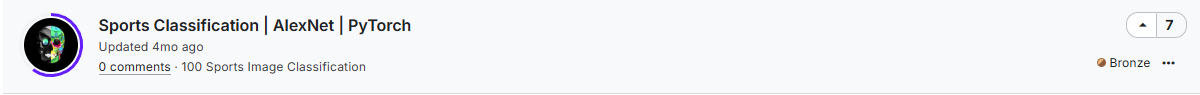

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary


In [4]:
# setting up torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cuda')

In [5]:
img_transforms  = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[-0.0932, -0.0971, -0.1260], std=[0.5091, 0.4912, 0.4931])
])

In [6]:
# create dataset using ImageFolder
data_path = "D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100"
data_path = data_path.replace('\\', '/')
train_path = data_path + '/train'
val_path = data_path + '/valid'
test_path = data_path + '/test'

train_data = ImageFolder(root=train_path, transform=img_transforms)
validation_data = ImageFolder(root=val_path, transform=img_transforms)
test_data = ImageFolder(root=test_path, transform=img_transforms)

len(train_data), len(validation_data), len(test_data)

(13492, 500, 500)

In [7]:
# create data loaders
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(dataset=validation_data, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False, num_workers=2)

len(train_dataloader), len(validation_dataloader), len(test_dataloader)

(422, 16, 16)

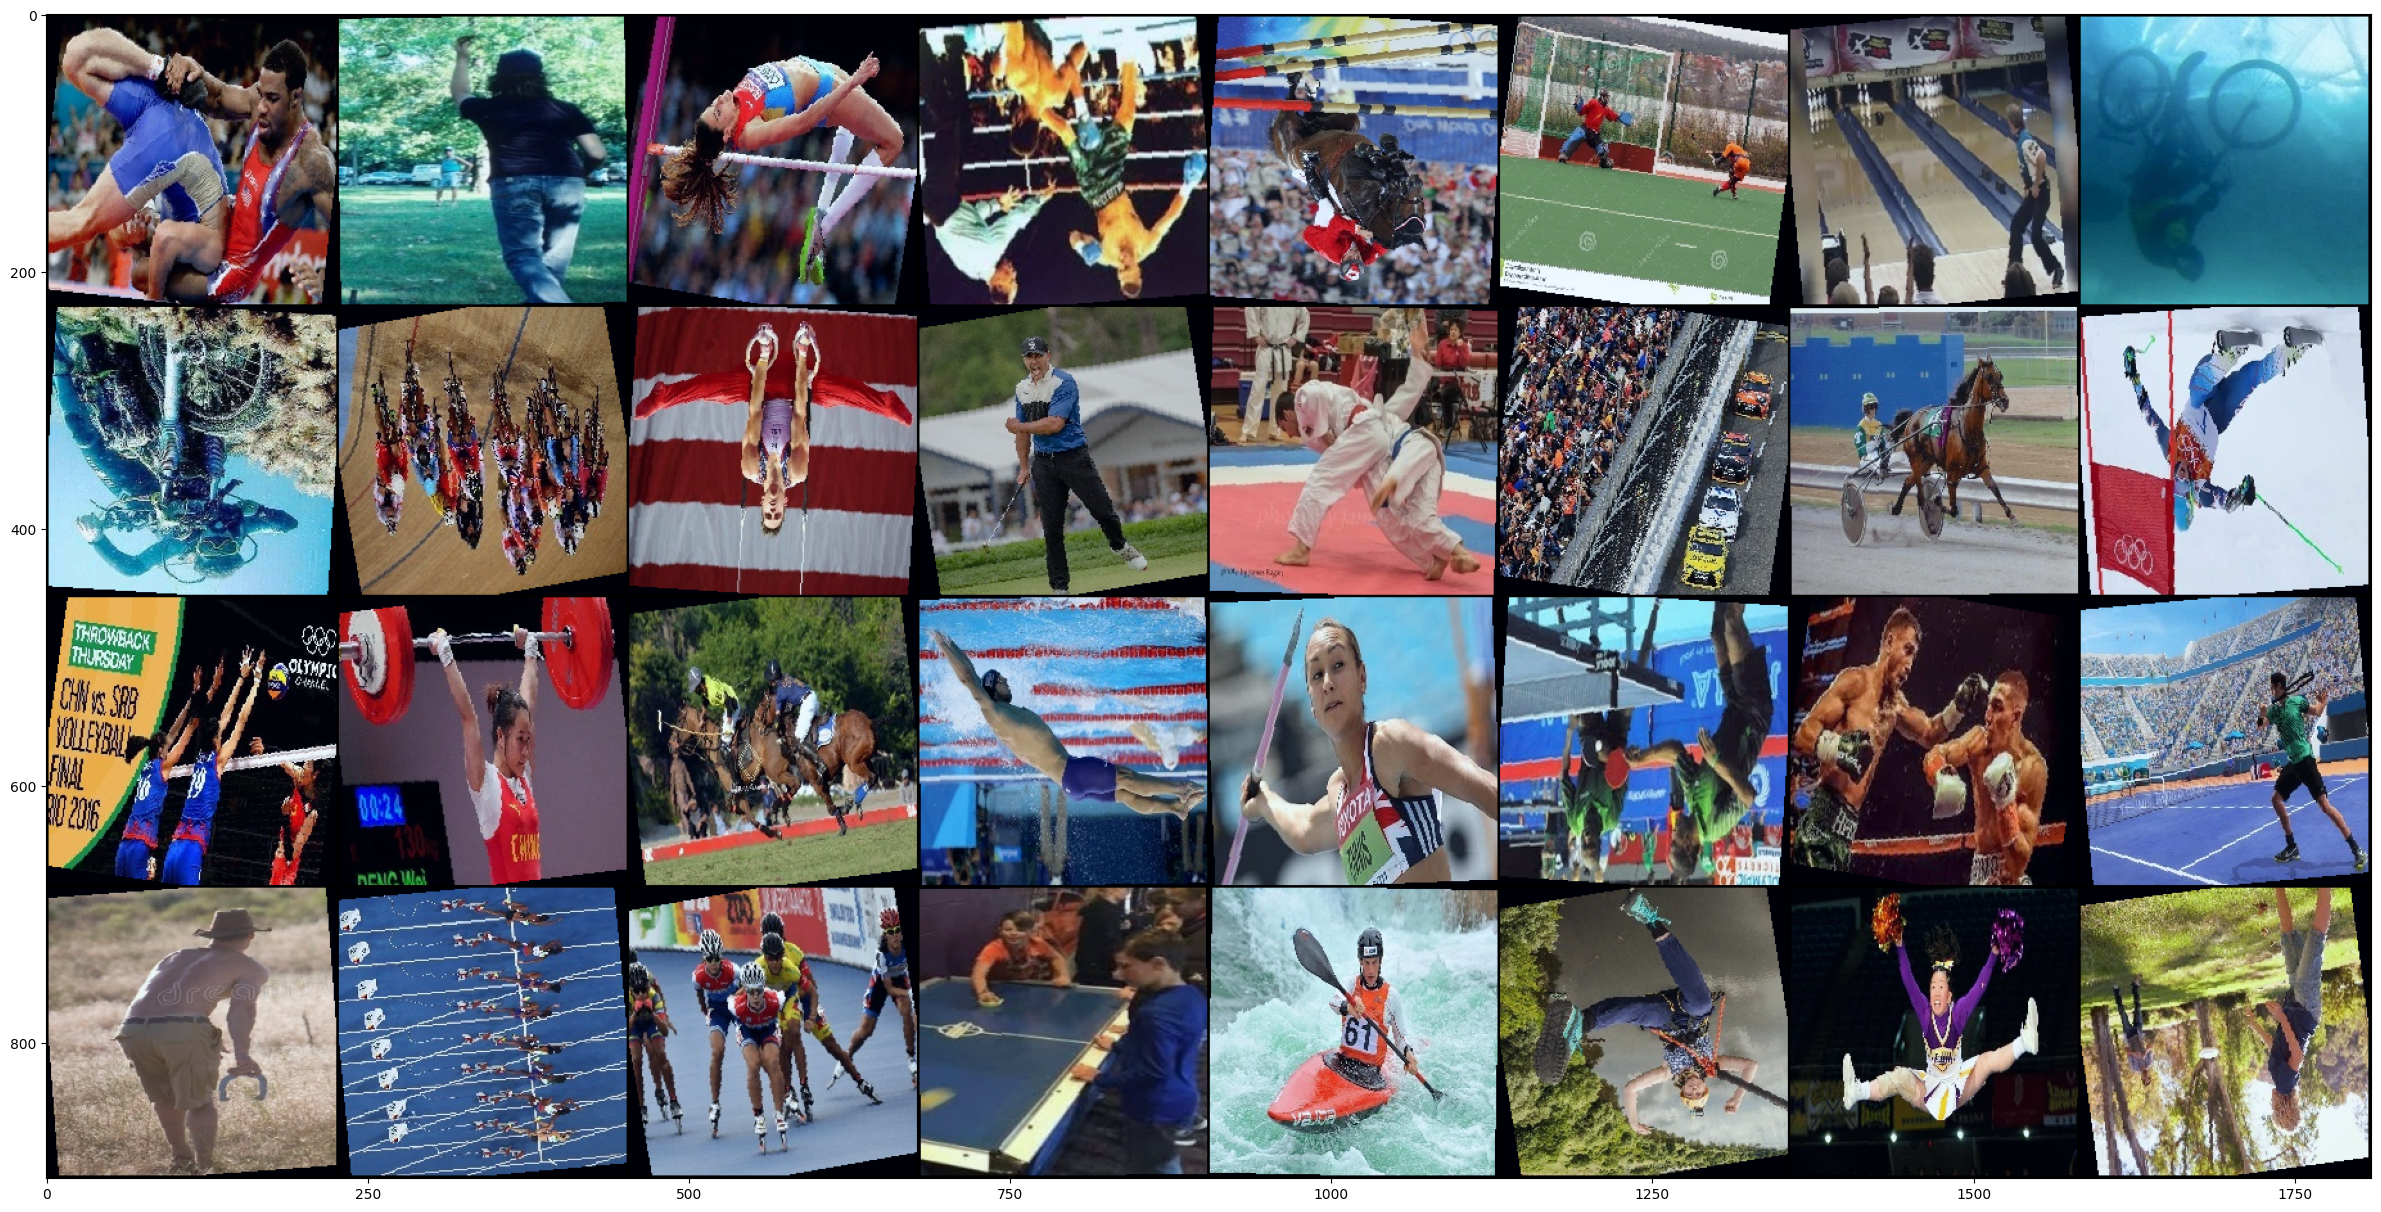

In [8]:
# visualize train data
def visualize(dataloader):
  images , labels = next(iter(dataloader))
  grid = make_grid(images, nrow=8, normalize=True)
  plt.figure(figsize=(30, 30))
  plt.imshow(np.transpose(grid, (1, 2, 0)))
  plt.show()
visualize(train_dataloader)

In [10]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.model = nn.Sequential(

            # First Convolutional Layer
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Second Convolutional Layer
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Third Convolutional Layer
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Fourth Convolutional Layer
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Fifth Convolutional Layer
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Flatten and Fully Connected Layers
            nn.Flatten(),
            nn.Linear(in_features=6400, out_features=4096),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(in_features=4096, out_features=2048),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(in_features=2048, out_features=100),  # Output layer

        )

    def forward(self, x):
        return self.model(x)

In [11]:
# create model instance
model = AlexNet().to(device)

In [12]:
summary(model=model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 100]                 --
├─Sequential: 1-1                        [32, 100]                 --
│    └─Conv2d: 2-1                       [32, 96, 54, 54]          34,944
│    └─ReLU: 2-2                         [32, 96, 54, 54]          --
│    └─MaxPool2d: 2-3                    [32, 96, 26, 26]          --
│    └─Conv2d: 2-4                       [32, 256, 26, 26]         614,656
│    └─ReLU: 2-5                         [32, 256, 26, 26]         --
│    └─MaxPool2d: 2-6                    [32, 256, 12, 12]         --
│    └─Conv2d: 2-7                       [32, 384, 12, 12]         885,120
│    └─ReLU: 2-8                         [32, 384, 12, 12]         --
│    └─Conv2d: 2-9                       [32, 384, 12, 12]         1,327,488
│    └─ReLU: 2-10                        [32, 384, 12, 12]         --
│    └─Conv2d: 2-11                      [32, 256, 12, 12]      

In [13]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [14]:
# train model
epochs = 40

training_loss = []
validation_loss = []

for epoch in range(epochs):

    # Training phase
    model.train()
    epoch_train_loss = 0.0
    for images, labels in train_dataloader:
        # Move data to the appropriate device
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        train_loss = loss_fn(outputs, labels)

        # Backward pass
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item() * images.size(0)  # Accumulate loss

    # Average training loss for the epoch
    epoch_train_loss /= len(train_dataloader.dataset)
    training_loss.append(epoch_train_loss)

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for val_images, val_labels in validation_dataloader:
            # Move validation data to the appropriate device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_labels)
            epoch_val_loss += val_loss.item() * val_images.size(0)  # Accumulate loss

    # Average validation loss for the epoch
    epoch_val_loss /= len(validation_dataloader.dataset)
    validation_loss.append(epoch_val_loss)

    # Print loss for the epoch
    print(f"Epoch: {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

Epoch: 1/40, Training Loss: 4.5871, Validation Loss: 4.5009
Epoch: 2/40, Training Loss: 4.3570, Validation Loss: 4.2548
Epoch: 3/40, Training Loss: 4.0810, Validation Loss: 3.9675
Epoch: 4/40, Training Loss: 3.7481, Validation Loss: 3.4712
Epoch: 5/40, Training Loss: 3.4883, Validation Loss: 3.2694
Epoch: 6/40, Training Loss: 3.2859, Validation Loss: 3.0245
Epoch: 7/40, Training Loss: 3.0741, Validation Loss: 2.9335
Epoch: 8/40, Training Loss: 2.9156, Validation Loss: 2.8251
Epoch: 9/40, Training Loss: 2.7492, Validation Loss: 2.5946
Epoch: 10/40, Training Loss: 2.5910, Validation Loss: 2.4804
Epoch: 11/40, Training Loss: 2.4544, Validation Loss: 2.4756
Epoch: 12/40, Training Loss: 2.3339, Validation Loss: 2.3425
Epoch: 13/40, Training Loss: 2.2157, Validation Loss: 2.1176
Epoch: 14/40, Training Loss: 2.1048, Validation Loss: 2.2020
Epoch: 15/40, Training Loss: 2.0028, Validation Loss: 2.1279
Epoch: 16/40, Training Loss: 1.9039, Validation Loss: 2.0681
Epoch: 17/40, Training Loss: 1.81

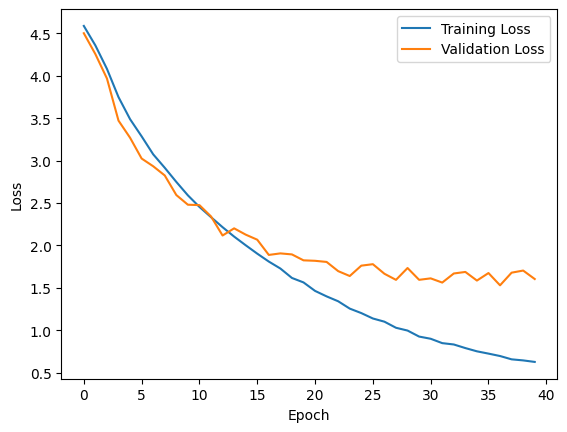

In [15]:
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Test model on test set
predicted_labels = []
actual_labels = []

model.eval()  # Set the model to evaluation mode
with torch.inference_mode():  # Ensure no gradients are computed
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

Model Accuracy: 64.60%
Model Precision: 67.83%
Model Recall: 64.60%
Model F1 Score: 63.19%
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.67      0.40      0.50         5
           2       0.67      0.80      0.73         5
           3       1.00      0.60      0.75         5
           4       0.75      0.60      0.67         5
           5       1.00      0.60      0.75         5
           6       1.00      0.40      0.57         5
           7       0.25      0.20      0.22         5
           8       0.75      0.60      0.67         5
           9       0.50      0.60      0.55         5
          10       1.00      0.40      0.57         5
          11       1.00      1.00      1.00         5
          12       0.40      0.40      0.40         5
          13       1.00      0.40      0.57         5
          14       1.00      0.60      0.75         5
          15       0.56      1.00      0.71 

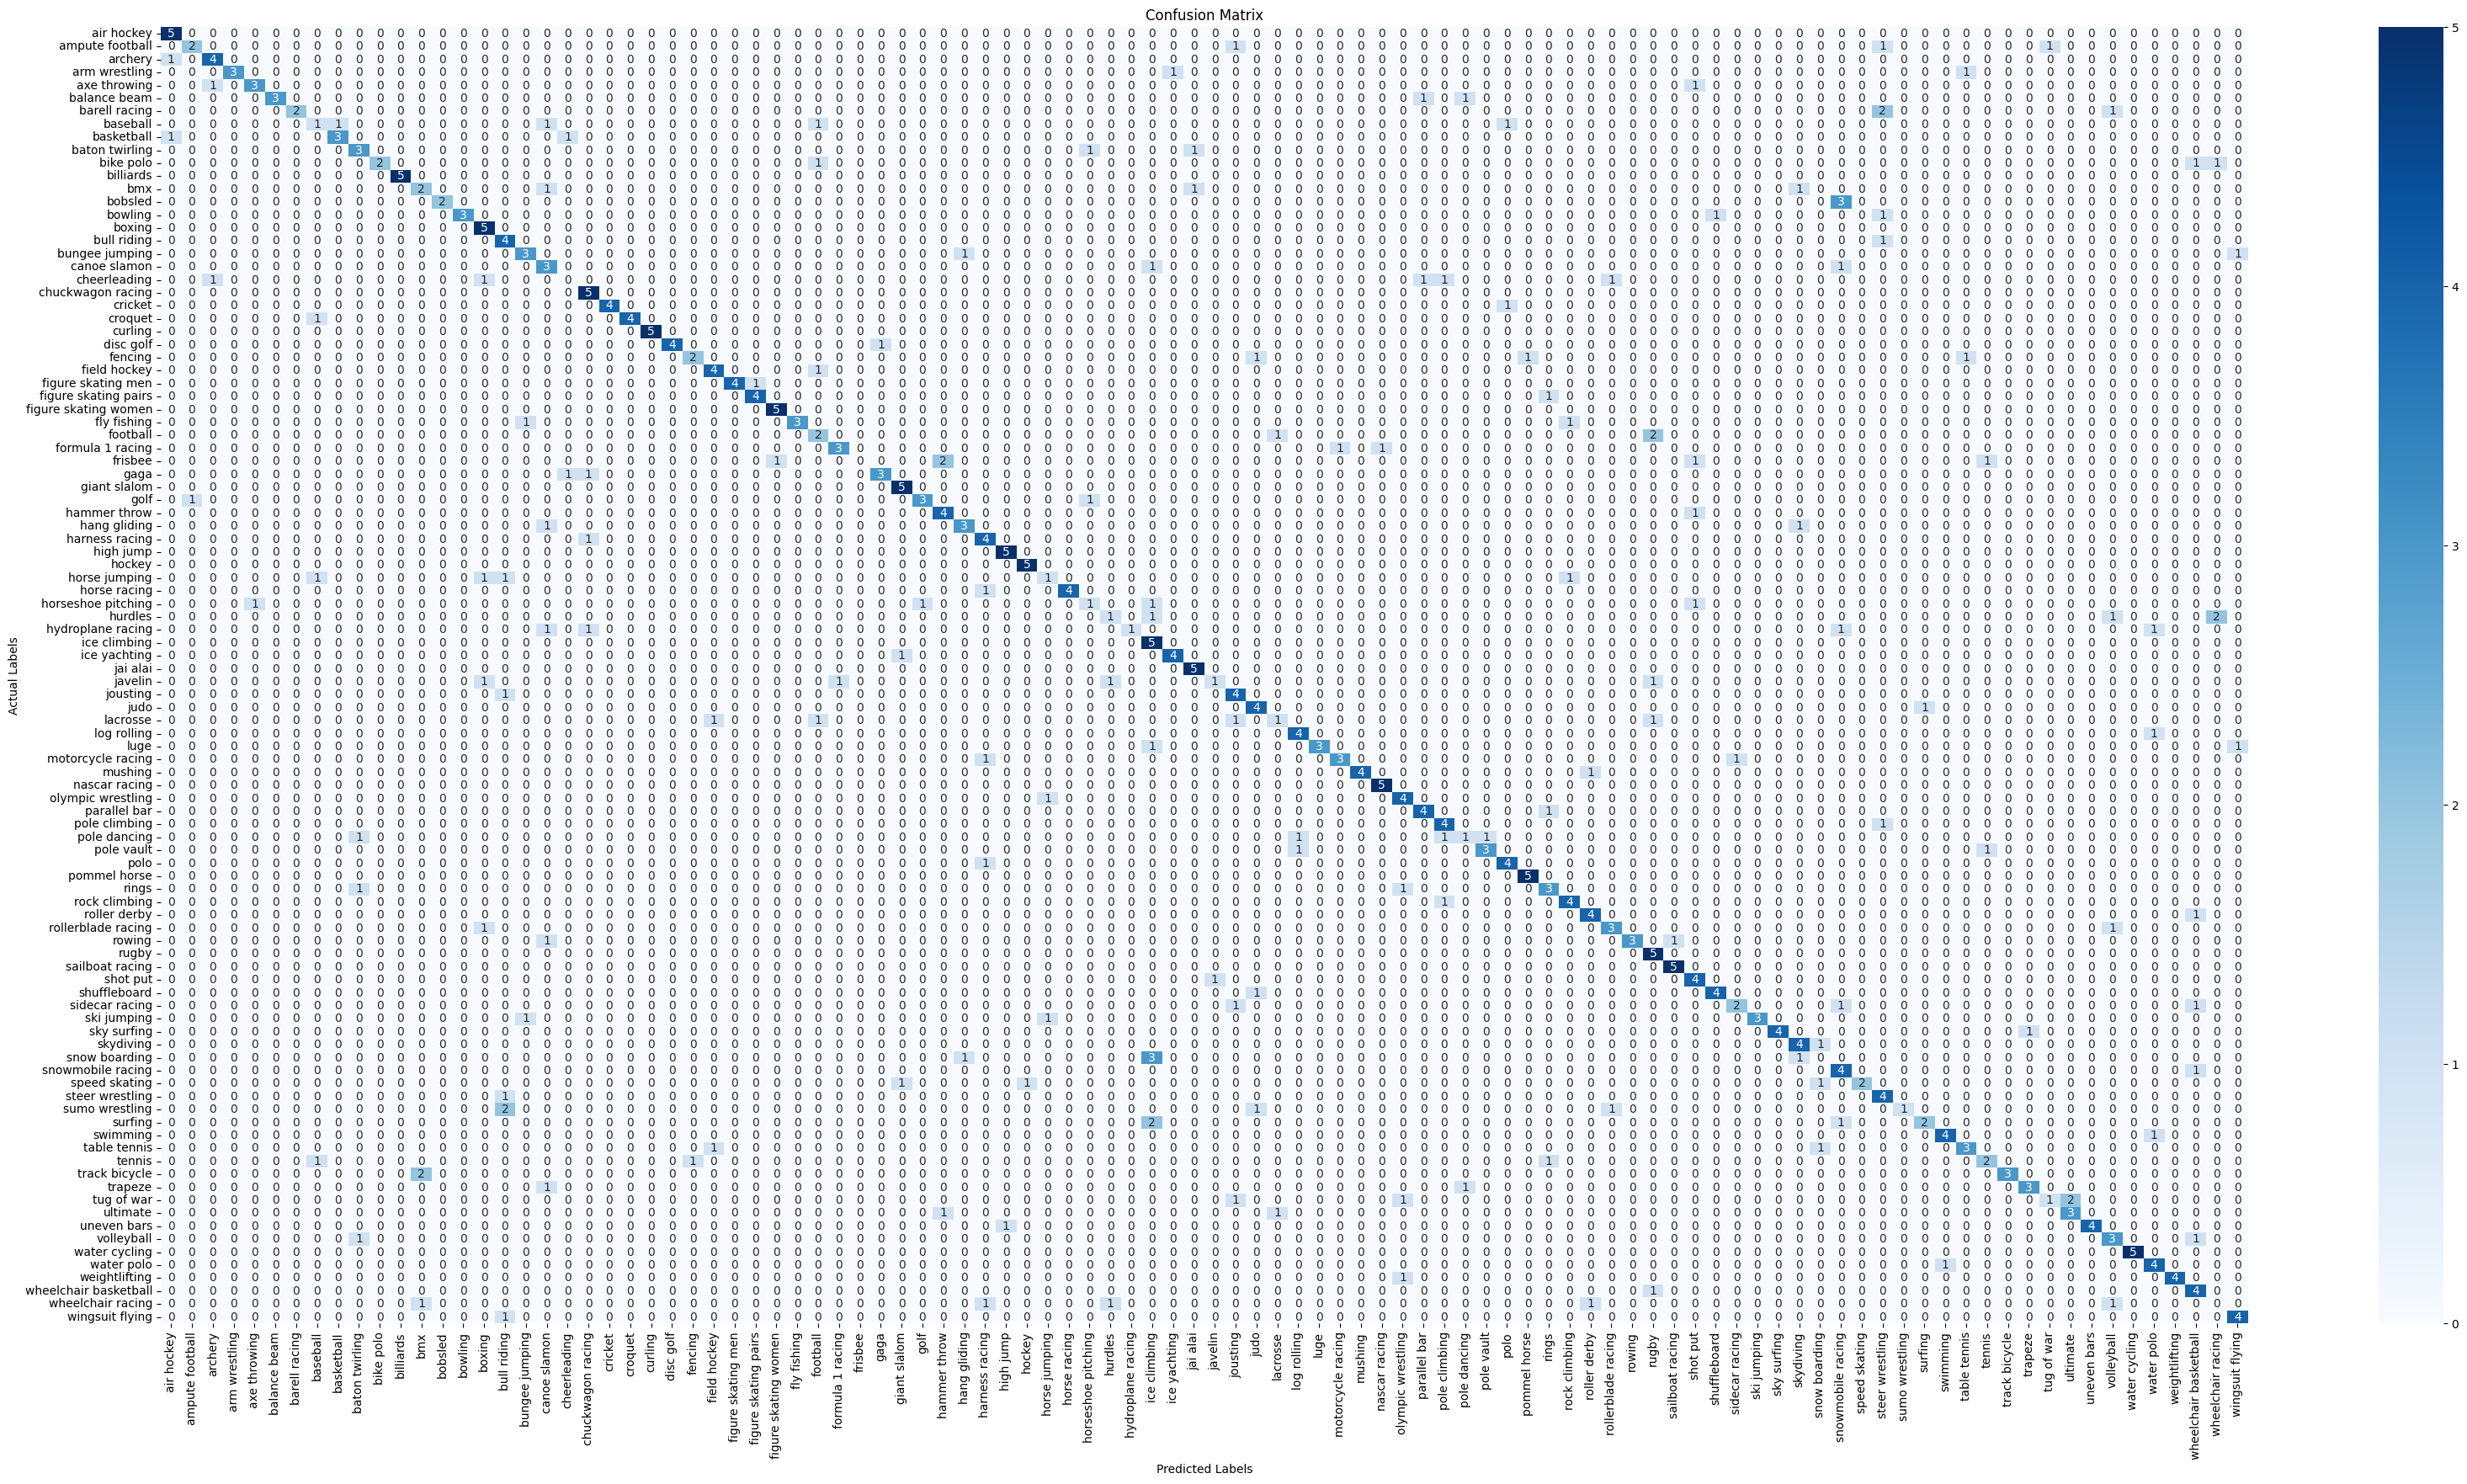

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average='weighted', zero_division=0)

# Print metrics
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print(f"Model Precision: {precision * 100:.2f}%")
print(f"Model Recall: {recall * 100:.2f}%")
print(f"Model F1 Score: {f1 * 100:.2f}%")

# Print classification report
print(classification_report(actual_labels, predicted_labels, zero_division=0))

# Generate and visualize confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
class_names = test_dataloader.dataset.classes

plt.figure(figsize=(40, 20))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [18]:
# save model
torch.save(model.state_dict(), 'alexnet.pth')